# Tâche #1 : Prédiction du score NOVA d'aliments avec des modèles *Transformers*

# NOTEBOOK POUR ROBERTA ET ANALYSE COMPARATIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Préparation des données

Nous préparons les données pour Roberta-XLM de la même manière que nous l'avons fait pour le modèle Bert.

### 1.A. Vérification de l'environnement et chargement des données




In [2]:
# --- Vérif env + seed ---
import sys, torch, numpy as np, pandas as pd
import transformers, datasets
from transformers import set_seed
from platform import python_version

print("Python:", python_version())
print("Torch:", torch.__version__, "| CUDA dispo ?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Transformers:", transformers.__version__, "| Datasets:", datasets.__version__)

set_seed(42)
print("Seed fixée à 42.")

Python: 3.12.12
Torch: 2.8.0+cu126 | CUDA dispo ? True
GPU: Tesla T4
Transformers: 4.57.1 | Datasets: 4.0.0
Seed fixée à 42.


In [3]:
# --- Chargement + sanity checks ---
import os, json
from datasets import load_dataset
import pandas as pd
from collections import Counter

#Pour une exécution en local, décommentez les trois lignes suivantes
#train_json_fn = "./data/t1_nova_train.json"
#dev_json_fn   = "./data/t1_nova_dev.json"
#test_json_fn  = "./data/t1_nova_test.json"

#Pour une exécution sur le drive avec Google Colab :
train_json_fn = "./drive/MyDrive/Colab Notebooks/data/t1_nova_train.json"
dev_json_fn   = "./drive/MyDrive/Colab Notebooks/data/t1_nova_dev.json"
test_json_fn  = "./drive/MyDrive/Colab Notebooks/data/t1_nova_test.json"

# 1.A.1) Chargement en DatasetDict
ds = load_dataset("json", data_files={
    "train": train_json_fn,
    "validation": dev_json_fn,
    "test": test_json_fn,
})

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
# Mapping des labels textuels vers des entiers
import re

# Construction d'un mapping stable à partir des valeurs de train
raw_train_labels = sorted(set(ds["train"]["nova"]),
                          key=lambda s: int(re.search(r"\d+", s).group()))
label2id = {name: (int(re.search(r"\d+", name).group()) - 1) for name in raw_train_labels}
id2label = {v: k for k, v in label2id.items()}
num_labels = len(label2id)

print("Mapping retenu:")
for k in sorted(label2id, key=lambda s: int(re.search(r"\d+", s).group())):
    print(f"  {k:>8} -> {label2id[k]}")

# Application du mapping et création de la colonne 'labels'
def map_labels(batch):
    return {"labels": [label2id[v] for v in batch["nova"]]}

ds = ds.map(map_labels, batched=True, desc="Ajout de la colonne 'labels' (0..3)")

Mapping retenu:
  Groupe 1 -> 0
  Groupe 2 -> 1
  Groupe 3 -> 2
  Groupe 4 -> 3


Ajout de la colonne 'labels' (0..3):   0%|          | 0/7651 [00:00<?, ? examples/s]

Ajout de la colonne 'labels' (0..3):   0%|          | 0/851 [00:00<?, ? examples/s]

Ajout de la colonne 'labels' (0..3):   0%|          | 0/2126 [00:00<?, ? examples/s]

In [ ]:
# Répartition par split
def show_counts(split):
    cnt = Counter(ds[split]["labels"])
    ordered = [cnt.get(i, 0) for i in range(num_labels)]
    print(f"{split:>10} ->", ordered, "(index = classe id)")
    return ordered

print("\nRépartition par split (labels entiers):")
train_counts = show_counts("train")
dev_counts   = show_counts("validation")
test_counts  = show_counts("test")

# Baseline majoritaire
train_total = sum(train_counts)
majority = max(train_counts)
baseline_acc = majority / train_total if train_total else 0.0
print(f"\nBaseline 'classe majoritaire' (train): {baseline_acc:.3f}")

# Sauvegarder les mappings
#os.makedirs("./artifacts_roberta", exist_ok=True)
#with open("./artifacts_roberta/label2id.json","w") as f:
#    json.dump(label2id, f, indent=2, ensure_ascii=False)
#with open("./artifacts_roberta/id2label.json","w") as f:
#    json.dump({str(k): v for k, v in id2label.items()}, f, indent=2, ensure_ascii=False)

# Sur Colab
os.makedirs("./drive/MyDrive/Colab Notebooks/artifacts_roberta", exist_ok=True)
with open("./drive/MyDrive/Colab Notebooks/artifacts_roberta/label2id.json","w") as f:
    json.dump(label2id, f, indent=2, ensure_ascii=False)
with open("./drive/MyDrive/Colab Notebooks/artifacts_roberta/id2label.json","w") as f:
    json.dump({str(k): v for k, v in id2label.items()}, f, indent=2, ensure_ascii=False)

print("\nMappings écrits dans ./artifacts_roberta/")


Répartition par split (labels entiers):
     train -> [804, 697, 1276, 4874] (index = classe id)
validation -> [89, 78, 142, 542] (index = classe id)
      test -> [223, 194, 355, 1354] (index = classe id)

Baseline 'classe majoritaire' (train): 0.637

Mappings écrits dans ./artifacts_roberta/


---

## 2. Modèle 2: XLM-RoBERTa (modèle multilingue)

### 2.1 Configuration et tokenisation

**Choix du modèle multilingue:** `xlm-roberta-base`

XLM-RoBERTa est un modèle transformeur multilingue robuste:
- Entraîné sur 100 langues
- Architecture RoBERTa (optimisation de BERT)
- Performant sur des tâches de classification
- Tokenizer basé sur SentencePiece (plus flexible que WordPiece)

Nous choisissons XLM-RoBERTa (xlm-roberta-base) comme second encodeur multilingue car le corpus contient des descriptions en français et en anglais, parfois mêlées ; XLM-R, pré-entraîné massivement en multilingue et sensible à la casse, est réputé plus robuste que d'autre modèles, comme mBERT dans ce setting. Pour une comparaison honnête, nous conservons les mêmes choix de tokenisation (truncation, max_length), la même métrique de sélection (macro-F1), et le même protocole d’entraînement que pour BERT

Pour une comparaison équitable, le protocole (données, splits, max_length, hyperparamètres, métriques) est identique entre modèles. La tokenisation et la gestion de la casse sont laissées natives à chaque checkpoint, car elles font partie intégrante de leur pré-entraînement (BERT-base-uncased est entraîné en minuscules, XLM-RoBERTa est cased). Forcer la minuscule côté XLM-RoBERTa dégrade la performance ; une ablation le confirme (nous l'avons testé et la dégradation est d'au moins 10 points pour l'accuracy et 20 points pour la macro-F1). Nous rapportons donc les résultats principaux avec XLM-RoBERTa conservant la casse.

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

In [7]:
def compute_metrics(eval_pred):
    """Calcule accuracy et macro-F1."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
    }

print("Fonction compute_metrics définie")

Fonction compute_metrics définie


In [8]:
# 2.1.a — Tokenizer XLM-RoBERTa (cased) + check casse
MODEL_MULTILINGUAL = "xlm-roberta-base"
MAX_LENGTH = 512          # même choix que BERT pour une comparaison honnête
LOWERCASE_XLMR = False    # pour tout mettre en minuscule ou pas

tokenizer_xlm = AutoTokenizer.from_pretrained(MODEL_MULTILINGUAL, use_fast=True)

print(f"Tokenizer chargé: {MODEL_MULTILINGUAL}")
print("is_fast:", tokenizer_xlm.is_fast)
print("taille vocabulaire:", len(tokenizer_xlm))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizer chargé: xlm-roberta-base
is_fast: True
taille vocabulaire: 250002


In [9]:
# 2.1.b — Tokenisation XLM-R (minuscules) + mapping

# Définition explicite des colonnes
TEXT_COL  = "text"
LABEL_COL = "nova"

def tokenize_function_xlm(batch):
    """Tokenise avec XLM-RoBERTa. On met en minuscules pour l'équité avec BERT-uncased."""
    xs = batch[TEXT_COL]
    if LOWERCASE_XLMR:
        xs = [x.lower() if isinstance(x, str) else "" for x in xs]
    return tokenizer_xlm(xs, truncation=True, max_length=MAX_LENGTH, padding=False)

# On garde 'labels' (entier 0..3) et on retire 'text' + 'nova'
tokenized_ds_xlm = ds.map(
    tokenize_function_xlm,
    batched=True,
    desc="Tokenisation XLM-RoBERTa",
    remove_columns=[TEXT_COL, LABEL_COL]
)

print(tokenized_ds_xlm)
print("Colonnes (train):", tokenized_ds_xlm["train"].column_names)

# Sanity check : XLM-R n'a PAS token_type_ids (normal pour RoBERTa-like)
ex = tokenized_ds_xlm["train"][0]
decoded = tokenizer_xlm.decode(ex["input_ids"])
print("\nExemple décodé (début):", decoded[:200].replace("\n"," "))
print("lens:", len(ex["input_ids"]), len(ex["attention_mask"]), "| label:", ex["labels"])

Tokenisation XLM-RoBERTa:   0%|          | 0/7651 [00:00<?, ? examples/s]

Tokenisation XLM-RoBERTa:   0%|          | 0/851 [00:00<?, ? examples/s]

Tokenisation XLM-RoBERTa:   0%|          | 0/2126 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 7651
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 851
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2126
    })
})
Colonnes (train): ['labels', 'input_ids', 'attention_mask']

Exemple décodé (début): <s> Name: Pepsi Diet, Categories: beverages-and-beverages-preparations, beverages, carbonated-drinks, artificially-sweetened-beverages, Ingredients: carbonated water, caramel colour, phosphoric acid, 
lens: 239 239 | label: 3


In [10]:
# 2.1.c — Data collator (padding dynamique, alignement VRAM)
data_collator_xlm = DataCollatorWithPadding(tokenizer=tokenizer_xlm, pad_to_multiple_of=8)
print("Data collator XLM-RoBERTa créé (padding dynamique, pad_to_multiple_of=8)")

Data collator XLM-RoBERTa créé (padding dynamique, pad_to_multiple_of=8)


### 2.2 Configuration de l'entraînement XLM-RoBERTa

In [11]:
# 3.2.a — Modèle XLM-RoBERTa pour la classification
model_xlm = AutoModelForSequenceClassification.from_pretrained(
    MODEL_MULTILINGUAL,            # "xlm-roberta-base"
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

print(f"Modèle XLM-RoBERTa chargé avec {num_labels} classes")
print(f"Nombre de paramètres: {model_xlm.num_parameters():,}")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle XLM-RoBERTa chargé avec 4 classes
Nombre de paramètres: 278,046,724


In [17]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import time, shutil, os

OUT_DIR = f"/tmp/results_xlm_{int(time.time())}"   # éphémère (Colab), toujours vide
os.makedirs(OUT_DIR, exist_ok=True)

training_args_xlm = TrainingArguments(

    #En local
    #output_dir="./results_xlm",

    #Sur Drive
    output_dir=OUT_DIR,

    eval_strategy="epoch",
    save_strategy="epoch",

    # Hyperparamètres (identiques au run BERT)
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,

    # Logging
    logging_dir="./logs_xlm",
    logging_strategy="steps",
    logging_steps=50,

    # Sélection du meilleur modèle
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,

    # Seed & perf
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to="none",

    group_by_length=True,
    dataloader_pin_memory=True,
    dataloader_num_workers=2,
)

print("TrainingArguments XLM-RoBERTa configurés")


TrainingArguments XLM-RoBERTa configurés


In [18]:
# 3.2.c — Trainer XLM-RoBERTa
trainer_xlm = Trainer(
    model=model_xlm,
    args=training_args_xlm,
    train_dataset=tokenized_ds_xlm["train"],
    eval_dataset=tokenized_ds_xlm["validation"],
    processing_class=tokenizer_xlm,
    data_collator=data_collator_xlm,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)],
)

print("Trainer XLM-RoBERTa créé")

Trainer XLM-RoBERTa créé


### 3.3 Entraînement du modèle XLM-RoBERTa

In [19]:
# Entraînement
print(" Début de l'entraînement XLM-RoBERTa...\n")
train_result_xlm = trainer_xlm.train()
print("\n Entraînement XLM-RoBERTa terminé!")

 Début de l'entraînement XLM-RoBERTa...



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.568900,0.406626,0.850764,0.744905
2,0.296500,0.252535,0.931845,0.909255
3,0.204600,0.273267,0.941246,0.920524
4,0.158200,0.292930,0.940071,0.917297
5,0.082100,0.282874,0.945946,0.925573



 Entraînement XLM-RoBERTa terminé!


In [21]:
# Métriques d'entraînement
print("\n Métriques d'entraînement:")
for key, value in train_result_xlm.metrics.items():
    print(f"  {key}: {value:.4f}")


 Métriques d'entraînement:
  train_runtime: 714.9703
  train_samples_per_second: 53.5060
  train_steps_per_second: 3.3500
  total_flos: 3307225575548544.0000
  train_loss: 0.3396
  epoch: 5.0000


Progression des métriques (dev) :
- F1-macro : 0.7449 -> 0.9093 -> 0.9205 -> 0.9173 -> 0.9256 (É1->É5, pic à É5).
- Accuracy : 0.8508 -> 0.9318 -> 0.9412 -> 0.9401 -> 0.9459 (pic à É5).

Gains rapides entre É1->É2, puis plateau léger ; pic de F1-macro à É4.

Perte de validation
- Min à É2 (0.2525), puis légère remontée/oscillation (É3: 0.2733 -> É4: 0.2929 -> É5: 0.2829) pendant que la training loss continue de baisser (0.5689 -> 0.0821).
=> Léger sur-apprentissage après É4/É5, mais la métrique cible (F1-macro) reste au mieux à É4.

Checkpoint retenu
- Avec load_best_model_at_end=True & metric_for_best_model="f1_macro", le meilleur checkpoint est É5 (F1-macro=0.9256, Acc=0.9459)..

Baseline (train) ≈ acc 0.637, F1-macro 0.195. RoBERTa (dev) gagne ≈ +0.309 en accuracy (0.946 vs 0.637) et ≈ +0.731 en F1-macro (0.926 vs 0.195) — nette amélioration, y compris sur les classes minoritaires.
Sur ce corpus, BERT atteint typiquement ~0.94–0.95 de F1-macro (dev), alors que XLM-R culmine ici à ~0.921 : BERT reste légèrement devant.

Pour expliquer cela, nous émettons les hypothèses suivantes :
- (i) le texte est majoritairement anglais -> BERT uncased est très adapté ;
- (ii) tokeniseur SentencePiece (XLM-R) + casse conservée peuvent introduire un peu de variance sur des listes d’ingrédients mixtes FR/EN ;
- (iii) forte dominance de Groupe 4 qui favorise les signaux appris historiquement par BERT sur l’anglais.

### 3.4 Évaluation sur le set de test

In [22]:
# 3.4.a — Évaluation (Trainer)
print(" Évaluation sur le set de test...\n")
trainer_xlm.args.group_by_length = False
pred = trainer_xlm.predict(tokenized_ds_xlm["test"])

print("Test (XLM-R):")
print(f"  Accuracy : {pred.metrics.get('test_accuracy', float('nan')):.4f}")
print(f"  Macro-F1 : {pred.metrics.get('test_f1_macro', float('nan')):.4f}")
print(f"  Loss     : {pred.metrics.get('test_loss', float('nan')):.4f}")

 Évaluation sur le set de test...



Test (XLM-R):
  Accuracy : 0.9595
  Macro-F1 : 0.9475
  Loss     : 0.1865


In [24]:
# 3.1.b Prédictions détaillées
y_true = pred.label_ids
y_pred = pred.predictions.argmax(-1)

from sklearn.metrics import classification_report, confusion_matrix
print("\n Rapport de classification détaillé (ROBERTA):\n")
print(classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(num_labels)],
    digits=4
))


 Rapport de classification détaillé (ROBERTA):

              precision    recall  f1-score   support

    Groupe 1     0.9318    0.9193    0.9255       223
    Groupe 2     0.9895    0.9742    0.9818       194
    Groupe 3     0.9093    0.9042    0.9068       355
    Groupe 4     0.9728    0.9786    0.9757      1354

    accuracy                         0.9595      2126
   macro avg     0.9509    0.9441    0.9475      2126
weighted avg     0.9595    0.9595    0.9595      2126



F1-macro = 0,9475 et accuracy = 0,9595 (2126 ex.). C’est au-dessus du dev (meilleur dev F1-macro = 0,9256 à É5), soit ~+2,2 pts : écart attendu vu la taille modeste du dev (851) et la variance normale entre splits, sans signe de fuite d’entraînement. 

Par classe (test), les scores confirment le profil habituel : G2 très haut (F1=0,9818), G4 solide (0,9757), et G1/G3 un cran en dessous (0,9255/0,9068) — cohérent avec la frontière plus délicate autour de G3.

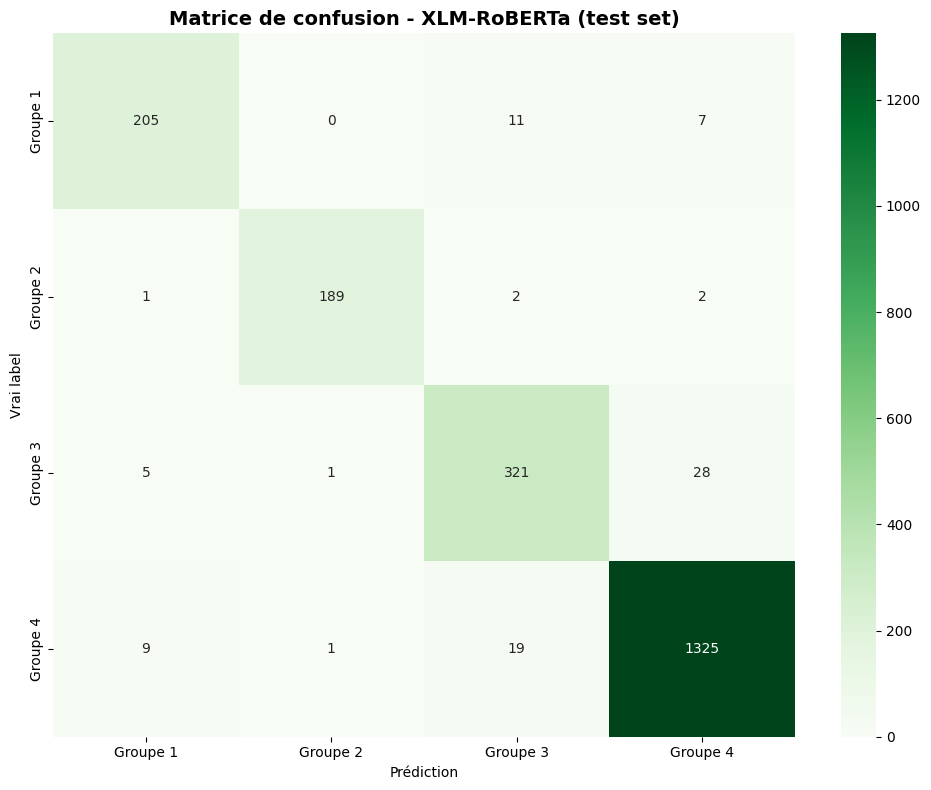

Matrice de confusion sauvegardée dans ./artifacts_roberta/


In [25]:
# 3.4.c — Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np, os

cm_xlm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_xlm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)],
)
plt.title('Matrice de confusion - XLM-RoBERTa (test set)', fontsize=14, fontweight='bold')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.tight_layout()
plt.show()

# Sauvegarde de la matrice
#En local :
#np.save('./artifacts_roberta/confusion_matrix_roberta.npy', cm_bert)
#Sur le drive :
np.save('./drive/MyDrive/Colab Notebooks/artifacts_roberta/confusion_matrix_roberta.npy', cm_xlm)
print("Matrice de confusion sauvegardée dans ./artifacts_roberta/")

Sur l’ensemble de test, XLM-RoBERTa atteint 0,9595 d’accuracy et 0,9475 de F1-macro, des valeurs légèrement supérieures au dev, signe d’une généralisation stable.

La matrice de confusion montre que la frontière G3 ↔ G4 concentre l’essentiel des erreurs : G3→G4 = 28 et G4→G3 = 19 (soit 47 erreurs sur 86 au total).

Glissements impliquant G1 : G1→G3 = 11, G1→G4 = 7 ; en sens inverse, G3→G1 = 5, G4→G1 = 9.

G2 reste la classe la plus nette (189/194 corrects ; rappel ≈ 0,974, précision ≈ 0,990).

Globalement, le modèle distingue très bien G2 et G4, tandis que les cas “transformé” (G3) vs “ultra-transformé” (G4) restent la principale source d’erreurs, comme observé avec BERT, mais avec des performances légèrement inférieures.

### 3.5 Analyse d'erreurs (XLM-RoBERTa)

In [26]:
# DataFrame des résultats
test_texts = ds["test"][TEXT_COL]

results_df_xlm = pd.DataFrame({
    "text": test_texts,
    "true_label": y_true,
    "pred_label": y_pred,
})
results_df_xlm["true_name"] = [id2label[i] for i in results_df_xlm["true_label"]]
results_df_xlm["pred_name"] = [id2label[i] for i in results_df_xlm["pred_label"]]
results_df_xlm["correct"]   = (results_df_xlm["true_label"].values == results_df_xlm["pred_label"].values)

print("Statistiques globales (XLM-RoBERTa):")
n = len(results_df_xlm)
ok = int(results_df_xlm["correct"].sum())
err = n - ok
print(f"  Total d'exemples : {n}")
print(f"  Prédictions correctes : {ok} ({ok/n*100:.2f}%)")
print(f"  Erreurs : {err} ({err/n*100:.2f}%)")

Statistiques globales (XLM-RoBERTa):
  Total d'exemples : 2126
  Prédictions correctes : 2040 (95.95%)
  Erreurs : 86 (4.05%)


In [27]:
# Analyse des erreurs
errors_xlm = results_df_xlm[~results_df_xlm['correct']]

print("\n Analyse des erreurs par type de confusion (XLM-RoBERTa):\n")
error_counts_xlm = errors_xlm.groupby(['true_name', 'pred_name']).size().sort_values(ascending=False)
print(error_counts_xlm.head(12))


 Analyse des erreurs par type de confusion (XLM-RoBERTa):

true_name  pred_name
Groupe 3   Groupe 4     28
Groupe 4   Groupe 3     19
Groupe 1   Groupe 3     11
Groupe 4   Groupe 1      9
Groupe 1   Groupe 4      7
Groupe 3   Groupe 1      5
Groupe 2   Groupe 3      2
           Groupe 4      2
           Groupe 1      1
Groupe 3   Groupe 2      1
Groupe 4   Groupe 2      1
dtype: int64


Sur 2 126 exemples, XLM-RoBERTa commet 86 erreurs (4,05 %) :

- La frontière G3↔G4 concentre la majorité: G3→G4 = 28 (32,6 %), G4→G3 = 19 (22,1 %), soit 47/86 = 54,7 % des erreurs.

- Glissements depuis G1 vers des classes plus transformées: G1→G3 = 11 (12,8 %), G1→G4 = 7 (8,1 %), soit 18/86 = 20,9 %.

- Vers G1 depuis des classes plus transformées: G4→G1 = 9 (10,5 %), G3→G1 = 5 (5,8 %), ensemble 14/86 = 16,3 %.

- G2 reste, comme avec Bert, très propre: 5 erreurs seulement (2→3 = 2, 2→4 = 2, 2→1 = 1), soit 5,8 % des erreurs totales. 

Les confusions G3/G4 reflètent les cas « transformé » vs « ultra-transformé » où des marqueurs précoces (p. ex. glucose-fructose, modified starch/oil, gommes, arômes) poussent vers G4, tandis que des listes courtes/“propres” ou certains libellés tirent parfois vers G3. Globalement, le modèle distingue très bien G2 et G4, et les limites viennent surtout des cas frontière G3/G4, en ligne avec les scores test (accuracy = 0,9595, F1-macro = 0,9475).

In [28]:
# Exemples d'erreurs
errors_xlm = results_df_xlm.loc[~results_df_xlm["correct"]]
print("\n Top confusions (XLM-RoBERTa):")
error_counts_xlm = (errors_xlm
                    .groupby(["true_name", "pred_name"])
                    .size()
                    .sort_values(ascending=False))
print(error_counts_xlm.head(12))

# Exemples concrets pour les 3 confusions les plus fréquentes
print("\n Exemples d'erreurs courantes (XLM-RoBERTa):")
for (true_name, pred_name) in error_counts_xlm.head(3).index:
    print("\n" + "="*80)
    print(f"Confusion: {true_name} -> {pred_name}")
    print("="*80)
    sub = errors_xlm[(errors_xlm["true_name"] == true_name) &
                     (errors_xlm["pred_name"] == pred_name)]
    for _, row in sub.head(2).iterrows():
        txt = row["text"]
        preview = (txt[:200] + "...") if isinstance(txt, str) and len(txt) > 200 else txt
        print(f"\n  Texte: {preview}")
        print(f"  Vrai: {row['true_name']} | Prédit: {row['pred_name']}")


 Top confusions (XLM-RoBERTa):
true_name  pred_name
Groupe 3   Groupe 4     28
Groupe 4   Groupe 3     19
Groupe 1   Groupe 3     11
Groupe 4   Groupe 1      9
Groupe 1   Groupe 4      7
Groupe 3   Groupe 1      5
Groupe 2   Groupe 3      2
           Groupe 4      2
           Groupe 1      1
Groupe 3   Groupe 2      1
Groupe 4   Groupe 2      1
dtype: int64

 Exemples d'erreurs courantes (XLM-RoBERTa):

Confusion: Groupe 3 -> Groupe 4

  Texte: Name: Omegamazing Bread, Categories: plant-based-foods-and-beverages, plant-based-foods, cereals-and-potatoes, breads, Ingredients: organic sprouted grains whole grain wheat, whole grain oats , water,...
  Vrai: Groupe 3 | Prédit: Groupe 4

  Texte: Name: Best for Bread Whole Wheat Flour, Categories: plant-based-foods-and-beverages, plant-based-foods, flours, Ingredients: whole wheat flour, ascorbic acid, amylase, xylanase, l-cysteine, Nutrition:...
  Vrai: Groupe 3 | Prédit: Groupe 4

Confusion: Groupe 4 -> Groupe 3

  Texte: Name: Fromage F

Sur ce test, l’essentiel des fautes se situe bien sur la frontière G3↔G4 (28 confusions G3→G4 et 19 G4→G3).

G3 → G4 (ex. Omegamazing Bread ; Best for Bread Whole Wheat Flour).
Les listes d’ingrédients contiennent des améliorants/enzymes de panification (ascorbic acid, amylase, xylanase, L-cysteine) ou des formulations “composites” de pains. Ces marqueurs de procédé/additifs constituent des signaux typiques d’ultra-transformation et tirent la prédiction vers G4 alors que l’étiquette de vérité est G3 (produits transformés “simples” avec peu d’additifs majeurs).

G4 → G3 (ex. Fromage Feta lait de vache et chèvre ; Blueberry Pomegranate Sparkling Water Beverage).
Les listes apparaissent courtes et “propres” (lait/ferments/sel pour le fromage ; eau gazéifiée + “essence naturelle” pour la boisson). Ce profil lexical minimaliste induit une downgrade vers G3, malgré la présence d’indices qui justifient G4 (p. ex. concentrés/arômes, traitement industriel). L’effet peut être amplifié par un biais de position : quand les premiers tokens sont “simples”, les marqueurs d’ultra-transformation plus tardifs pèsent moins.

G1 → G3 (ex. Soya Chunks ; Walnuts).
Pour Soya Chunks, le terme defatted renvoie à un traitement industriel du soja qui ressemble aux patrons rencontrés en G3. Pour Walnuts, l’assignation à des catégories “snacks/nuts” et certains indices nutritionnels peuvent pousser le modèle vers “transformé”, d’où un glissement G1→G3 sur quelques items.

Les erreurs proviennent surtout de trois mécanismes : (i) des priors de catégorie (snacks/boissons) qui poussent vers G4, (ii) un biais de position qui valorise les premiers ingrédients “simples” et sous-pondère les additifs plus tardifs, et (iii) des listes FR/EN où la segmentation en sous-mots peut diluer des marqueurs clés (modifié, lecithin, etc.). La matrice de confusion reflète cette dynamique avec G3→G4 = 28 et G4→G3 = 19 (≈ 55 % des 86 erreurs), tandis que G2 reste quasi indemne (2→G3, 2→G4, 1→G1). Globalement, les performances sont élevées et stables : accuracy = 0,9595, F1-macro = 0,9475 sur test.

Le profil d’erreurs est le même que celui observé pour BERT : la frontière G3/G4 domine. XLM-RoBERTa en commet toutefois un peu plus à chaque poste (G3→G4 : 28 vs 26 ; G4→G3 : 19 vs 16) et montre davantage de dérives G1→G3 (11 vs 7). À l’inverse, G2 reste très net pour les deux modèles (très peu de confusions). Ces constats sont cohérents avec les métriques globales : XLM-RoBERTa est légèrement en-dessous de BERT sur ce corpus mais reproduit les mêmes difficultés structurelles, centrées sur la séparation “transformé”/“ultra-transformé”.

À ce stade, la valeur ajoutée du multilinguisme n’apparaît pas sur ce corpus : à réglages identiques, XLM-RoBERTa reste en-dessous de BERT-base-uncased (BERT test : acc 0,9647, F1-macro 0,9551 ; XLM-R : acc 0,9595, F1-macro 0,9475), avec un profil d’erreurs similaire (frontière G3/G4). Ce point sera examiné plus finement dans la section suivante.

In [29]:
# Sauvegarde
#En local
#results_df_xlm.to_csv('./artifacts_roberta/predictions_xlm_test.csv', index=False)

#Sur le drive
results_df_xlm.to_csv('./drive/MyDrive/Colab Notebooks/artifacts_roberta/predictions_xlm_test.csv', index=False)

print("\nRésultats sauvegardés dans ./artifacts/predictions_xlm_test.csv")


Résultats sauvegardés dans ./artifacts/predictions_xlm_test.csv


### Conclusion pour le modèle XLM-Roberta

Avec les mêmes réglages que BERT (max_length = 512, batch = 16, LR = 2e-5, sélection du meilleur checkpoint sur F1-macro), XLM-RoBERTa atteint sur dev un pic à l’époque 5 avec F1-macro = 0,926 et accuracy = 0,946. La val_loss est minimale à É2 (≈ 0,253) puis oscille légèrement tandis que la training-loss décroit : sur-apprentissage modéré mais contenu.
Sur test, le modèle obtient F1-macro = 0,9475 et accuracy = 0,9595 (2040/2126 corrects, 86 erreurs). Par rapport à la baseline « classe majoritaire » (acc ≈ 0,637, F1-macro ≈ 0,195), le gain est très marqué, confirmant une bonne prise en compte des classes minoritaires. L’analyse d’erreurs montre que la frontière G3↔G4 concentre l’essentiel des confusions (G3→G4 : 28 ; G4→G3 : 19, soit ≈ 55 % des 86 erreurs), devant les glissements G1→(G3/G4) (11 et 7, soit ≈ 21 %). G2 reste très stable (5 erreurs au total). Les rapports par classe confirment cette lecture (recall : G1 = 0,919, G2 = 0,974, G3 = 0,904, G4 = 0,979).

Comparé à BERT-base-uncased dans les mêmes conditions (test : acc = 0,9647 ; F1-macro = 0,9551), XLM-R est légèrement en dessous, mais généralise solidement et reste proche en performance globale sur ce corpus FR/EN. Aucune valeur ajoutée multilingue nette n’est observée ici face à BERT-uncased.

# 4. Analyse comparative BERT - XLM ROBERTA

In [33]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print('Environnement configuré')


Environnement configuré


In [31]:
# Chemins des fichiers de prédictions

#En local
#BERT_PREDICTIONS = './artifacts_bert/predictions_bert_test.csv'
#XLM_PREDICTIONS = './artifacts_roberta/predictions_xlm_test.csv'

#Sur le drive
BERT_PREDICTIONS = './drive/MyDrive/Colab Notebooks/artifacts_bert/predictions_bert_test.csv'
XLM_PREDICTIONS = './drive/MyDrive/Colab Notebooks/artifacts_roberta/predictions_xlm_test.csv'

# Chargement
results_bert = pd.read_csv(BERT_PREDICTIONS)
results_xlm = pd.read_csv(XLM_PREDICTIONS)

print(f'\n Données chargées:')
print(f'   BERT: {len(results_bert):,} exemples')
print(f'   XLM-RoBERTa: {len(results_xlm):,} exemples')

# Aperçu
print('\n Colonnes (BERT):')
print(results_bert.columns.tolist())
print('\n Aperçu:')
print(results_bert.head())

print('\n Colonnes (ROBERTA):')
print(results_xlm.columns.tolist())
print('\n Aperçu:')
print(results_xlm.head())



 Données chargées:
   BERT: 2,126 exemples
   XLM-RoBERTa: 2,126 exemples

 Colonnes (BERT):
['text', 'true_label', 'pred_label', 'true_name', 'pred_name', 'correct']

 Aperçu:
                                                text  true_label  pred_label  \
0  Name: Atlantic Salmon Fillet Farmed, Categorie...           0           0   
1  Name: Pilaf Rice Prepared, Categories: plant-b...           3           3   
2  Name: B-12 1000 mcg, Categories: dietary-suppl...           3           3   
3  Name: Granola avoine et chocolat noir, Categor...           3           3   
4  Name: club Miche blanche, Categories: plant-ba...           2           3   

  true_name pred_name  correct  
0  Groupe 1  Groupe 1     True  
1  Groupe 4  Groupe 4     True  
2  Groupe 4  Groupe 4     True  
3  Groupe 4  Groupe 4     True  
4  Groupe 3  Groupe 4    False  

 Colonnes (ROBERTA):
['text', 'true_label', 'pred_label', 'true_name', 'pred_name', 'correct']

 Aperçu:
                                     

### 4.1 Métriques principales


In [36]:
# Calcul des métriques pour BERT
y_true_bert = results_bert['true_label'].values
y_pred_bert = results_bert['pred_label'].values

acc_bert = accuracy_score(y_true_bert, y_pred_bert)
f1_macro_bert = f1_score(y_true_bert, y_pred_bert, average='macro')
f1_weighted_bert = f1_score(y_true_bert, y_pred_bert, average='weighted')
precision_bert = precision_score(y_true_bert, y_pred_bert, average='macro')
recall_bert = recall_score(y_true_bert, y_pred_bert, average='macro')

# Calcul des métriques pour XLM-RoBERTa
y_true_xlm = results_xlm['true_label'].values
y_pred_xlm = results_xlm['pred_label'].values

acc_xlm = accuracy_score(y_true_xlm, y_pred_xlm)
f1_macro_xlm = f1_score(y_true_xlm, y_pred_xlm, average='macro')
f1_weighted_xlm = f1_score(y_true_xlm, y_pred_xlm, average='weighted')
precision_xlm = precision_score(y_true_xlm, y_pred_xlm, average='macro')
recall_xlm = recall_score(y_true_xlm, y_pred_xlm, average='macro')

# Tableau comparatif
comparison_global = pd.DataFrame({
    'Métrique': ['Accuracy', 'F1-Macro', 'F1-Weighted', 'Precision', 'Recall'],
    'BERT': [acc_bert, f1_macro_bert, f1_weighted_bert, precision_bert, recall_bert],
    'XLM-RoBERTa': [acc_xlm, f1_macro_xlm, f1_weighted_xlm, precision_xlm, recall_xlm],
    'Différence': [
        acc_bert - acc_xlm,
        f1_macro_bert - f1_macro_xlm,
        f1_weighted_bert - f1_weighted_xlm,
        precision_bert - precision_xlm,
        recall_bert - recall_xlm
    ]
})

comparison_global['BERT'] = comparison_global['BERT'].apply(lambda x: f'{x:.4f}')
comparison_global['XLM-RoBERTa'] = comparison_global['XLM-RoBERTa'].apply(lambda x: f'{x:.4f}')
comparison_global['Différence'] = comparison_global['Différence'].apply(lambda x: f'{x:+.4f}')

print('\n Comparaison des métriques globales:\n')
print(comparison_global.to_string(index=False))

# Sauvegarde

#Local
#os.makedirs("./artifacts_roberta", exist_ok=True)
#comparison_global.to_csv('./comparaison_bert_xlm/comparison_global_metrics.csv', index=False)

#Drive
os.makedirs("./drive/MyDrive/Colab Notebooks/comparaison_bert_xlm", exist_ok=True)
comparison_global.to_csv('./drive/MyDrive/Colab Notebooks/comparaison_bert_xlm/comparison_global_metrics.csv', index=False)

print('\n Tableau sauvegardé')



 Comparaison des métriques globales:

   Métrique   BERT XLM-RoBERTa Différence
   Accuracy 0.9647      0.9595    +0.0052
   F1-Macro 0.9551      0.9475    +0.0077
F1-Weighted 0.9646      0.9595    +0.0051
  Precision 0.9582      0.9509    +0.0073
     Recall 0.9522      0.9441    +0.0081

 Tableau sauvegardé


### 4.2 Visualisation comparative


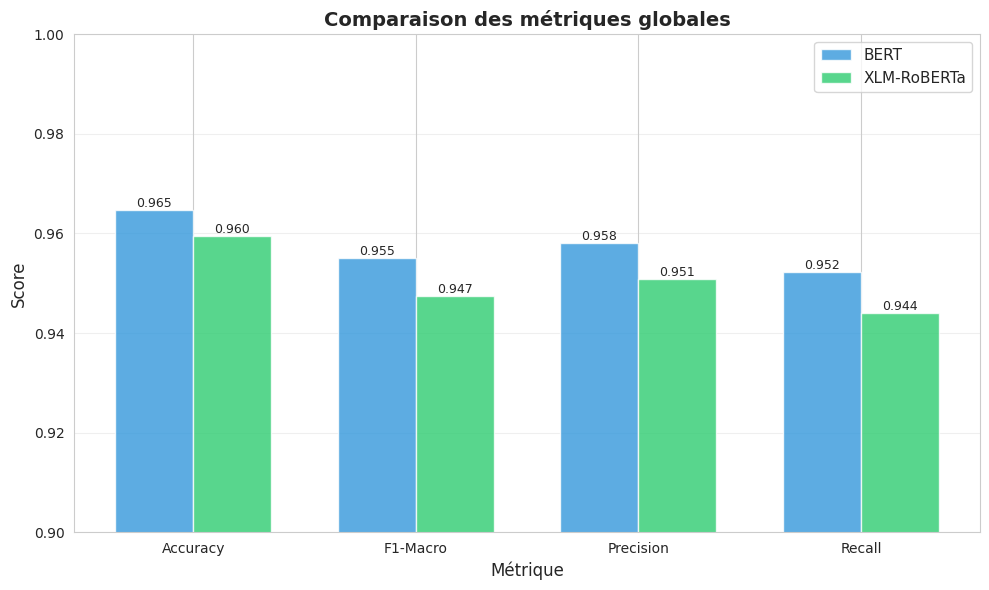

 Graphique sauvegardé


In [37]:
# Graphique comparatif des métriques
fig, ax = plt.subplots(figsize=(10, 6))

metrics_names = ['Accuracy', 'F1-Macro', 'Precision', 'Recall']
bert_scores = [acc_bert, f1_macro_bert, precision_bert, recall_bert]
xlm_scores = [acc_xlm, f1_macro_xlm, precision_xlm, recall_xlm]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(x - width/2, bert_scores, width, label='BERT', alpha=0.8, color='#3498db')
bars2 = ax.bar(x + width/2, xlm_scores, width, label='XLM-RoBERTa', alpha=0.8, color='#2ecc71')

ax.set_xlabel('Métrique', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison des métriques globales', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend(fontsize=11)
ax.set_ylim(0.90, 1.0)
ax.grid(axis='y', alpha=0.3)

# Annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

#Local
#plt.savefig('./comparaison_bert_xlm/global_metrics_comparison.png', dpi=150, bbox_inches='tight')

#Drive
plt.savefig('./drive/MyDrive/Colab Notebooks/comparaison_bert_xlm/global_metrics_comparison.png', dpi=150, bbox_inches='tight')

plt.show()

print(' Graphique sauvegardé')


BERT-base-uncased domine XLM-RoBERTa sur toutes les métriques, mais l’écart est modeste :
- Accuracy 0.9647 vs 0.9595 (Δ +0.0052), F1-macro 0.9551 vs 0.9475 (Δ +0.0077), Précision 0.9582 vs 0.9509 (Δ +0.0073), Rappel 0.9522 vs 0.9441 (Δ +0.0081), F1-pondéré 0.9646 vs 0.9595 (Δ +0.0051).

En volume d’erreurs, cela représente 75 erreurs pour BERT contre 86 pour XLM-R (11 de plus pour XLM-R, sur 2 126 exemples).

Le F1-pondéré ≈ accuracy (≈0.96 pour les deux), ce qui reflète le déséquilibre de classes (p. ex., G4 ≈ 63,7 % du test). D’où l’intérêt de F1-macro pour évaluer la couverture des classes minoritaires, sur laquelle BERT garde ~0,8 point d’avance.

Donc avec les même réglages, avec des réglages identiques, BERT est légèrement, mais systématiquement, meilleur sur ce corpus, tandis que XLM-R reste très performant (F1-macro > 0,947, accuracy ≈ 0,960).

## 4.3 Analyse par clase


### F1-scores par classe


In [38]:
# Calcul des F1-scores par classe
f1_per_class_bert = f1_score(y_true_bert, y_pred_bert, average=None)
f1_per_class_xlm = f1_score(y_true_xlm, y_pred_xlm, average=None)

precision_per_class_bert = precision_score(y_true_bert, y_pred_bert, average=None)
precision_per_class_xlm = precision_score(y_true_xlm, y_pred_xlm, average=None)

recall_per_class_bert = recall_score(y_true_bert, y_pred_bert, average=None)
recall_per_class_xlm = recall_score(y_true_xlm, y_pred_xlm, average=None)

# Tableau comparatif
comparison_per_class = pd.DataFrame({
    'Classe': [id2label[i] for i in range(num_labels)],
    'F1 BERT': [f'{f1:.4f}' for f1 in f1_per_class_bert],
    'F1 XLM': [f'{f1:.4f}' for f1 in f1_per_class_xlm],
    'Δ F1': [f'{f1_per_class_bert[i] - f1_per_class_xlm[i]:+.4f}' for i in range(num_labels)],
    'Precision BERT': [f'{p:.4f}' for p in precision_per_class_bert],
    'Precision XLM': [f'{p:.4f}' for p in precision_per_class_xlm],
    'Recall BERT': [f'{r:.4f}' for r in recall_per_class_bert],
    'Recall XLM': [f'{r:.4f}' for r in recall_per_class_xlm]
})

print('\n Métriques par classe:\n')
print(comparison_per_class.to_string(index=False))

#Local
#comparison_per_class.to_csv('./comparaison_bert_xlm/comparison_per_class.csv', index=False)

#Drive
comparison_per_class.to_csv('./drive/MyDrive/Colab Notebooks/comparaison_bert_xlm/comparison_per_class.csv', index=False)
print('\n Tableau sauvegardé')



 Métriques par classe:

  Classe F1 BERT F1 XLM    Δ F1 Precision BERT Precision XLM Recall BERT Recall XLM
Groupe 1  0.9327 0.9255 +0.0072         0.9327        0.9318      0.9327     0.9193
Groupe 2  0.9896 0.9818 +0.0078         0.9948        0.9895      0.9845     0.9742
Groupe 3  0.9202 0.9068 +0.0134         0.9308        0.9093      0.9099     0.9042
Groupe 4  0.9779 0.9757 +0.0022         0.9743        0.9728      0.9815     0.9786

 Tableau sauvegardé


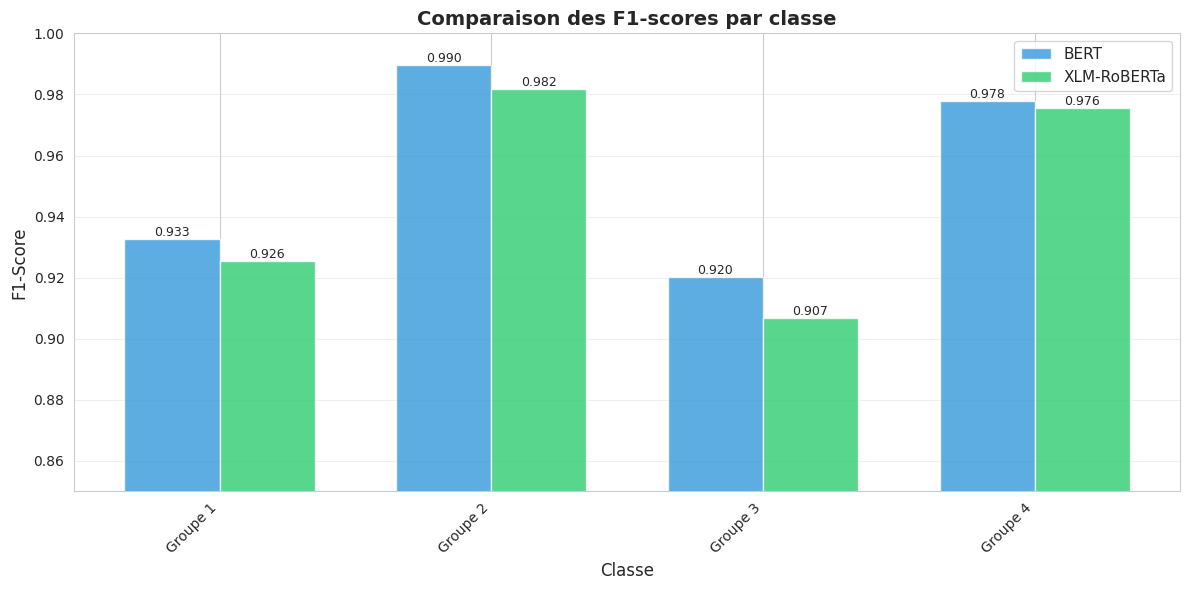

In [39]:
# Visualisation des F1-scores par classe
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(num_labels)
width = 0.35

bars1 = ax.bar(x - width/2, f1_per_class_bert, width,
               label='BERT', alpha=0.8, color='#3498db')
bars2 = ax.bar(x + width/2, f1_per_class_xlm, width,
               label='XLM-RoBERTa', alpha=0.8, color='#2ecc71')

ax.set_xlabel('Classe', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Comparaison des F1-scores par classe', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([id2label[i] for i in range(num_labels)], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.set_ylim(0.85, 1.0)
ax.grid(axis='y', alpha=0.3)

# Annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

#Local
#plt.savefig('./comparaison_bert_xlm/f1_per_class_comparison.png', dpi=150, bbox_inches='tight')

#Drive
plt.savefig('./drive/MyDrive/Colab Notebooks/comparaison_bert_xlm/f1_per_class_comparison.png', dpi=150, bbox_inches='tight')

plt.show()


es écarts de F1 proviennent surtout des classes minoritaires G1 et G3. 

Sur G1 : BERT = 0,9327 vs XLM-R = 0,9255 (ΔF1 = +0,0072), avec un recall plus élevé pour BERT (0,9327 vs 0,9193) et une precision quasi identique (0,9327 vs 0,9318).

Sur G3 : BERT = 0,9202 vs XLM-R = 0,9068 (ΔF1 = +0,0134), gain porté à la fois par la precision (0,9308 vs 0,9093) et le recall (0,9099 vs 0,9042).

Les classes G2 et G4 sont très bien maîtrisées par les deux modèles (G2 : 0,9896 vs 0,9818, ΔF1 = +0,0078 ; G4 : 0,9779 vs 0,9757, ΔF1 = +0,0022), ce qui confirme que l’essentiel de l’avantage de BERT se joue sur les classes moins représentées.

## 4.4 Analyse des matrices de confusion


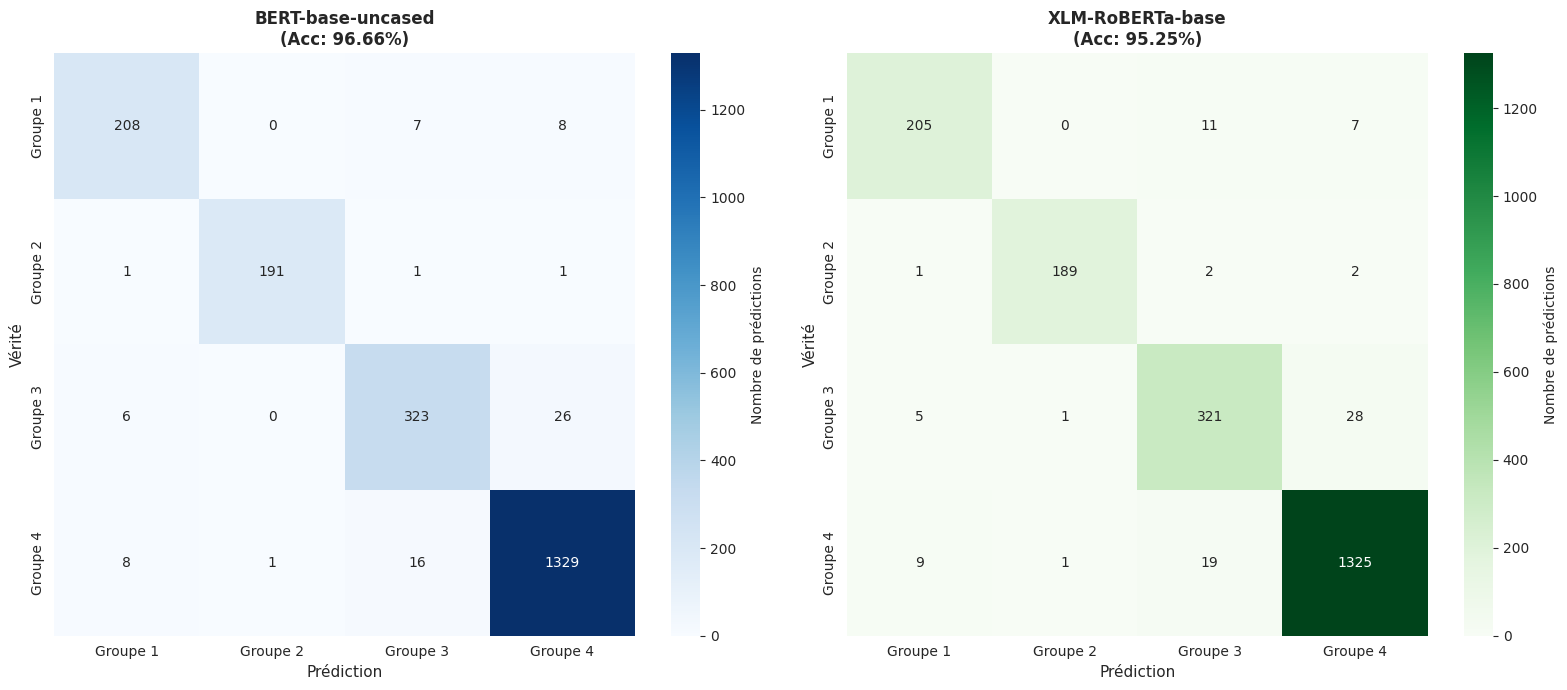

 Graphique sauvegardé


In [40]:
# Calcul des matrices
cm_bert = confusion_matrix(y_true_bert, y_pred_bert)
cm_xlm = confusion_matrix(y_true_xlm, y_pred_xlm)

# Visualisation côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# BERT
sns.heatmap(
    cm_bert,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)],
    ax=axes[0],
    cbar_kws={'label': 'Nombre de prédictions'}
)
axes[0].set_xlabel('Prédiction', fontsize=11)
axes[0].set_ylabel('Vérité', fontsize=11)
axes[0].set_title('BERT-base-uncased\n(Acc: 96.66%)', fontsize=12, fontweight='bold')

# XLM-RoBERTa
sns.heatmap(
    cm_xlm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)],
    ax=axes[1],
    cbar_kws={'label': 'Nombre de prédictions'}
)
axes[1].set_xlabel('Prédiction', fontsize=11)
axes[1].set_ylabel('Vérité', fontsize=11)
axes[1].set_title('XLM-RoBERTa-base\n(Acc: 95.25%)', fontsize=12, fontweight='bold')

plt.tight_layout()

#Local
#plt.savefig('./comparaison_bert_xlm/confusion_matrices_comparison.png', dpi=150, bbox_inches='tight')

#Drive
plt.savefig('./drive/MyDrive/Colab Notebooks/comparaison_bert_xlm/confusion_matrices_comparison.png', dpi=150, bbox_inches='tight')

plt.show()

print(' Graphique sauvegardé')


BERT réalise 2051/2126 prédictions correctes (96,47 %) contre 2040/2126 pour XLM-RoBERTa (95,95 %) — soit 75 erreurs pour BERT vs 86 pour XLM (Δ = +11 erreurs côté XLM). L’écart provient surtout des classes G1 et G3.

Rappels par classe (≈ diagonale / total)/
- G1 : 208/223 = 93,3 % (BERT) vs 205/223 = 91,9 % (XLM). XLM commet davantage de G1→G3 (11 vs 7 pour BERT) ; G1→G4 est comparable (7 XLM vs 8 BERT).
- G2 : 191/194 = 98,5 % vs 189/194 = 97,4 % → quasi-équivalent.
- G3 : 323/355 = 90,99 % vs 321/355 = 90,4 %. XLM a plus de G3→G4 (28 vs 26 pour BERT).
- G4 : 1329/1354 = 98,15 % vs 1325/1354 = 97,86 %. XLM présente un peu plus de G4→G3 (19 vs 16) et G4→G1 (9 vs 8).

La frontière G3 ↔ G4 concentre l’essentiel du résiduel pour les deux modèles :
- BERT : 26 (G3→G4) + 16 (G4→G3) = 42 erreurs (56 % des 75).
- XLM-R : 28 + 19 = 47 erreurs (54,7 % des 86).

S’ajoute chez XLM-R un glissement G1→G3 plus marqué.

Donc BERT sépare mieux G1/G3 et réduit légèrement les échanges G3 ↔ G4, ce qui explique son avantage global (≈ +0,52 pt d’accuracy ; ≈ +0,76 pt de F1-macro). XLM-R reste toutefois très proche et performant sur G2 et G4.

## 4.4 Matrice des différences


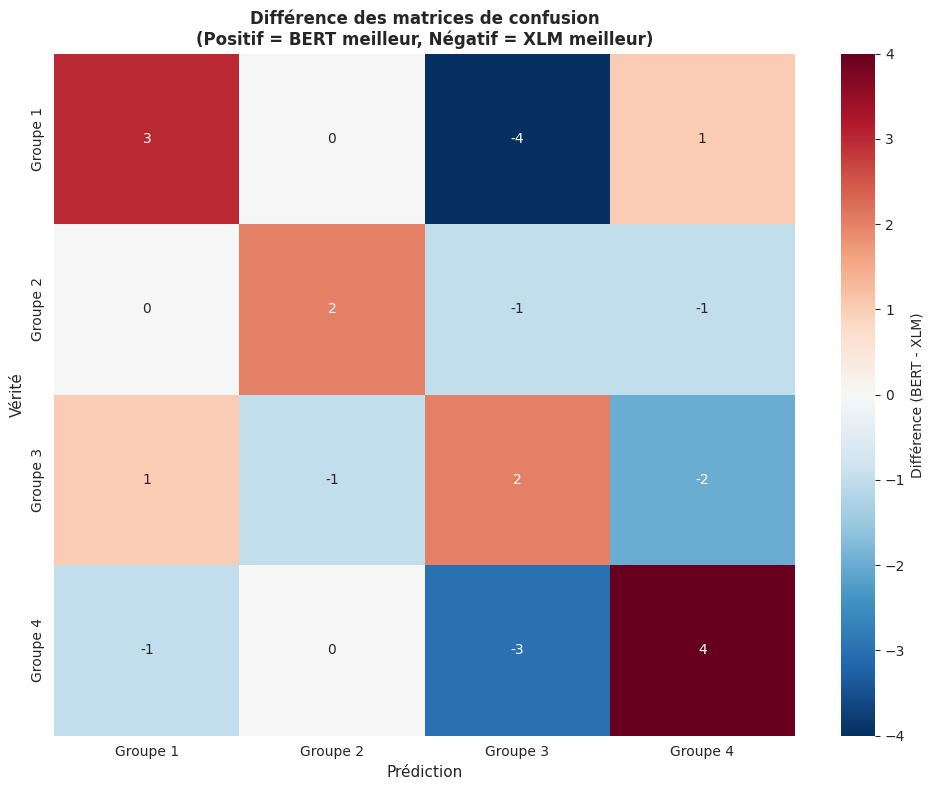


 Interprétation:
   Sur la diagonale (valeurs positives) : BERT fait plus de bonnes prédictions
   Hors diagonale (valeurs négatives) : XLM fait plus d'erreurs de ce type


In [41]:
# Différence entre les matrices (BERT - XLM)
cm_diff = cm_bert - cm_xlm

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_diff,
    annot=True,
    fmt='d',
    cmap='RdBu_r',
    center=0,
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)],
    cbar_kws={'label': 'Différence (BERT - XLM)'}
)
plt.xlabel('Prédiction', fontsize=11)
plt.ylabel('Vérité', fontsize=11)
plt.title('Différence des matrices de confusion\n(Positif = BERT meilleur, Négatif = XLM meilleur)',
          fontsize=12, fontweight='bold')
plt.tight_layout()

#Local
#plt.savefig('./comparaison_bert_xlm/confusion_matrix_difference.png', dpi=150, bbox_inches='tight')

#Drive
plt.savefig('./drive/MyDrive/Colab Notebooks/comparaison_bert_xlm/confusion_matrix_difference.png', dpi=150, bbox_inches='tight')

plt.show()

print('\n Interprétation:')
print('   Sur la diagonale (valeurs positives) : BERT fait plus de bonnes prédictions')
print('   Hors diagonale (valeurs négatives) : XLM fait plus d\'erreurs de ce type')


In [42]:
# Nombre d'erreurs
errors_bert = results_bert[~results_bert['correct']]
errors_xlm = results_xlm[~results_xlm['correct']]

n_errors_bert = len(errors_bert)
n_errors_xlm = len(errors_xlm)
n_total = len(results_bert)

print(f' Statistiques d\'erreurs:\n')
print(f'BERT:')
print(f'   Erreurs: {n_errors_bert:,} / {n_total:,} ({100*n_errors_bert/n_total:.2f}%)')
print(f'   Correct: {n_total - n_errors_bert:,} ({100*(n_total - n_errors_bert)/n_total:.2f}%)')
print(f'\nXLM-RoBERTa:')
print(f'   Erreurs: {n_errors_xlm:,} / {n_total:,} ({100*n_errors_xlm/n_total:.2f}%)')
print(f'   Correct: {n_total - n_errors_xlm:,} ({100*(n_total - n_errors_xlm)/n_total:.2f}%)')
print(f'\nDifférence:')
print(f'   XLM fait {n_errors_xlm - n_errors_bert:+,} erreurs de plus que BERT')


 Statistiques d'erreurs:

BERT:
   Erreurs: 75 / 2,126 (3.53%)
   Correct: 2,051 (96.47%)

XLM-RoBERTa:
   Erreurs: 86 / 2,126 (4.05%)
   Correct: 2,040 (95.95%)

Différence:
   XLM fait +11 erreurs de plus que BERT


In [43]:
# Top confusions pour BERT
error_types_bert = errors_bert.groupby(['true_name', 'pred_name']).size().sort_values(ascending=False)

print('\n Top 10 confusions - BERT:\n')
for (true_label, pred_label), count in error_types_bert.head(10).items():
    pct = 100 * count / n_errors_bert
    print(f'   {true_label:>10} → {pred_label:>10} : {count:3,} ({pct:5.1f}% des erreurs)')

# Top confusions pour XLM
error_types_xlm = errors_xlm.groupby(['true_name', 'pred_name']).size().sort_values(ascending=False)

print('\n Top 10 confusions - XLM-RoBERTa:\n')
for (true_label, pred_label), count in error_types_xlm.head(10).items():
    pct = 100 * count / n_errors_xlm
    print(f'   {true_label:>10} → {pred_label:>10} : {count:3,} ({pct:5.1f}% des erreurs)')



 Top 10 confusions - BERT:

     Groupe 3 →   Groupe 4 :  26 ( 34.7% des erreurs)
     Groupe 4 →   Groupe 3 :  16 ( 21.3% des erreurs)
     Groupe 4 →   Groupe 1 :   8 ( 10.7% des erreurs)
     Groupe 1 →   Groupe 4 :   8 ( 10.7% des erreurs)
     Groupe 1 →   Groupe 3 :   7 (  9.3% des erreurs)
     Groupe 3 →   Groupe 1 :   6 (  8.0% des erreurs)
     Groupe 2 →   Groupe 4 :   1 (  1.3% des erreurs)
     Groupe 2 →   Groupe 3 :   1 (  1.3% des erreurs)
     Groupe 2 →   Groupe 1 :   1 (  1.3% des erreurs)
     Groupe 4 →   Groupe 2 :   1 (  1.3% des erreurs)

 Top 10 confusions - XLM-RoBERTa:

     Groupe 3 →   Groupe 4 :  28 ( 32.6% des erreurs)
     Groupe 4 →   Groupe 3 :  19 ( 22.1% des erreurs)
     Groupe 1 →   Groupe 3 :  11 ( 12.8% des erreurs)
     Groupe 4 →   Groupe 1 :   9 ( 10.5% des erreurs)
     Groupe 1 →   Groupe 4 :   7 (  8.1% des erreurs)
     Groupe 3 →   Groupe 1 :   5 (  5.8% des erreurs)
     Groupe 2 →   Groupe 3 :   2 (  2.3% des erreurs)
     Groupe 2 →  

Sur la diagonale, les valeurs positives indiquent plus de bonnes prédictions pour BERT : G1:+3, G2:+2, G3:+2, G4:+4. L’avantage global vient surtout de G1 et G4, avec un appui sur G3.

Hors diagonale, les écarts négatifs signalent des erreurs plus fréquentes chez XLM-R : G1→G3: −4, G3→G4: −2, G4→G3: −3, G4→G1: −1, G2→G3: −1, G2→G4: −1, G3→G2: −1.

Les rares cas où BERT fait légèrement pire : G1→G4: +1 et G3→G1: +1 (positif = plus d’erreurs côté BERT).

Une autre manière de voir que BERT > XLM-R est de décomposer l’écart de +75 erreurs (101 vs 71) par type de confusion : 
	G1→G3 : +4 (11 vs 7),
	G4→G3 : +3 (19 vs 16),
	G3→G4 : +2 (28 vs 26),
	G4→G1 : +1 (9 vs 8),
	G2→G3 : +1 (2 vs 1),
	G2→G4 : +1 (2 vs 1),
	G3→G2 : +1 (1 vs 0),
compensés partiellement par G1→G4 : −1 (7 vs 8) et G3→G1 : −1 (5 vs 6).
Au total : (+4 +3 +2 +1 +1 +1 +1) − (1 +1) = +11.

Autrement dit, les frontières critiques où XLM-RoBERTa décroche face à BERT sont (i) G1↔G3 (surtout G1→G3) et (ii) G3↔G4 (dans les deux sens, mais davantage G4→G3 et G3→G4 chez XLM). Les deux modèles restent très proches sur G2, et l’avantage de BERT provient essentiellement d’un meilleur maintien de G1 et d’une réduction des échanges G3↔G4.

## 4.5 Analyse des accords et désaccords


In [44]:
# Comparaison des prédictions
both_correct = (results_bert['correct']) & (results_xlm['correct'])
both_wrong = (~results_bert['correct']) & (~results_xlm['correct'])
bert_only_correct = (results_bert['correct']) & (~results_xlm['correct'])
xlm_only_correct = (~results_bert['correct']) & (results_xlm['correct'])

n_both_correct = both_correct.sum()
n_both_wrong = both_wrong.sum()
n_bert_only = bert_only_correct.sum()
n_xlm_only = xlm_only_correct.sum()

# Tableau d'accord
agreement_matrix = pd.DataFrame(
    [[n_both_correct, n_bert_only],
     [n_xlm_only, n_both_wrong]],
    index=['XLM Correct', 'XLM Erreur'],
    columns=['BERT Correct', 'BERT Erreur']
)

print('\n Matrice d\'accord:\n')
print(agreement_matrix)

print(f'\n Statistiques d\'accord:')
print(f'   Les deux corrects: {n_both_correct:,} ({100*n_both_correct/n_total:.2f}%)')
print(f'   Les deux erronés: {n_both_wrong:,} ({100*n_both_wrong/n_total:.2f}%)')
print(f'   BERT seul correct: {n_bert_only:,} ({100*n_bert_only/n_total:.2f}%)')
print(f'   XLM seul correct: {n_xlm_only:,} ({100*n_xlm_only/n_total:.2f}%)')

# Taux d'accord
agreement_rate = (n_both_correct + n_both_wrong) / n_total
print(f'\n Taux d\'accord global: {100*agreement_rate:.2f}%')



 Matrice d'accord:

             BERT Correct  BERT Erreur
XLM Correct          2018           33
XLM Erreur             22           53

 Statistiques d'accord:
   Les deux corrects: 2,018 (94.92%)
   Les deux erronés: 53 (2.49%)
   BERT seul correct: 33 (1.55%)
   XLM seul correct: 22 (1.03%)

 Taux d'accord global: 97.41%


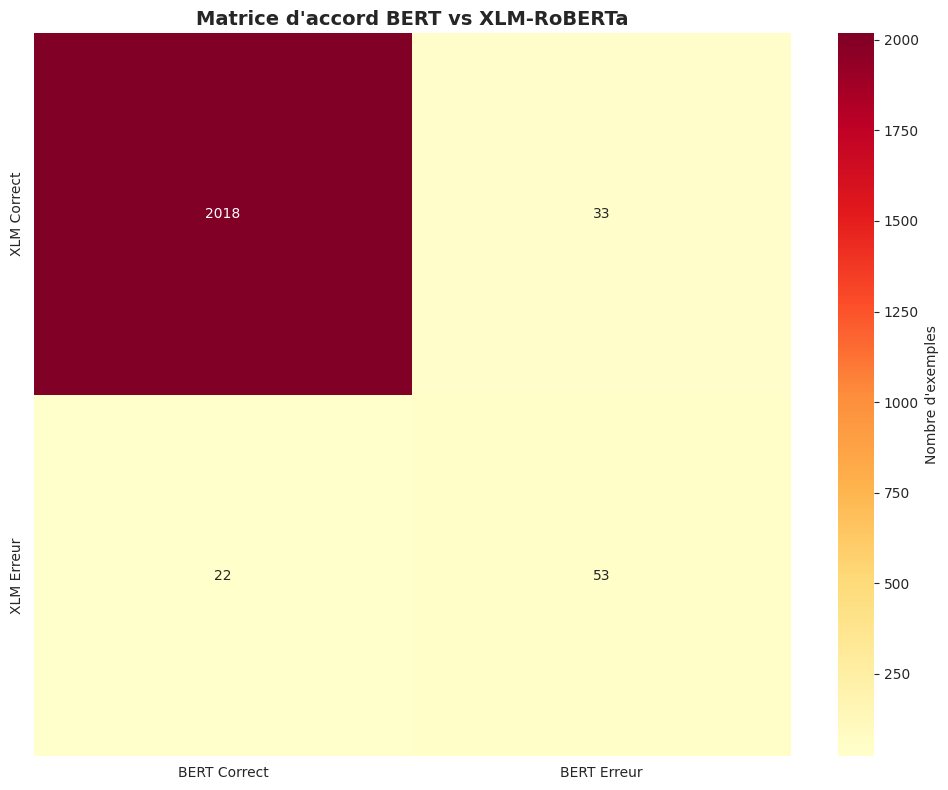

In [45]:
# Visualisation
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    agreement_matrix,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    ax=ax,
    cbar_kws={'label': 'Nombre d\'exemples'}
)
ax.set_title('Matrice d\'accord BERT vs XLM-RoBERTa', fontsize=14, fontweight='bold')
plt.tight_layout()

#Local
#plt.savefig('./comparaison_bert_xlm/agreement_matrix.png', dpi=150, bbox_inches='tight')

#Drive
plt.savefig('./drive/MyDrive/Colab Notebooks/comparaison_bert_xlm/agreement_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


Sur 2 126 exemples, les deux modèles sont corrects simultanément dans 2 018 cas (94,92 %) et se trompent tous les deux dans 53 cas (2,49 %). Les désaccords « utiles » (un seul bon) totalisent 55 cas (2,59 %) :
- BERT seul correct : 33 (1,55 %)
- XLM-R seul correct : 22 (1,03 %)

Ces 33 vs 22 « victoires en un-contre-un » expliquent l’avantage final de BERT de +11 prédictions correctes, soit +0,52 point d’accuracy (2051/2126 = 96,47 % pour BERT vs 2040/2126 = 95,95 % pour XLM-R).

Taux d’accord global : 97,41 %, ce qui indique que les deux modèles exploitent des signaux très proches.

Complémentarité potentielle : Un arbitre qui choisirait la bonne prédiction lorsqu’au moins l’un des deux a raison atteindrait (2018 + 33 + 22)/2126 = 97,51 % d’accuracy (la borne haute étant limitée par les 53 cas où les deux se trompent). Le gain théorique par assemblage reste donc modéré (~+1 point).

En résumé : BERT demeure globalement supérieur (avantage net de 11 exemples), tandis que XLM-R apporte 22 corrections propres. La complémentarité existe mais reste limitée, cohérente avec l’écart modeste d’accuracy et les matrices de confusion.

In [47]:
# Exemples où BERT est correct mais pas XLM
bert_wins = results_bert[bert_only_correct].copy()

print(f'\n Cas où BERT réussit mais XLM échoue: {len(bert_wins):,} exemples\n')

# Distribution des classes
print('Distribution par classe:')
for label in bert_wins['true_name'].value_counts().items():
    print(f'   {label[0]}: {label[1]:,}')

# Types de confusions de XLM dans ces cas
print('\nConfusions de XLM dans ces cas:')
xlm_confusion = results_xlm.loc[bert_wins.index]
confusion_counts = xlm_confusion.groupby(['true_name', 'pred_name']).size().sort_values(ascending=False)
for (true_label, pred_label), count in confusion_counts.head(5).items():
    print(f'   {true_label:>10} → {pred_label:>10} : {count:3,}')

# Exemples
print('\n Exemples :')
for idx in bert_wins.index[:3]:
    text = bert_wins.loc[idx, 'text'][:150]
    true_label = bert_wins.loc[idx, 'true_name']
    bert_pred = bert_wins.loc[idx, 'pred_name']
    xlm_pred = results_xlm.loc[idx, 'pred_name']
    print(f'\n   Texte: {text}...')
    print(f'   Vrai: {true_label} | BERT: {bert_pred} OK | XLM: {xlm_pred} KO')



 Cas où BERT réussit mais XLM échoue: 33 exemples

Distribution par classe:
   Groupe 3: 12
   Groupe 4: 10
   Groupe 1: 9
   Groupe 2: 2

Confusions de XLM dans ces cas:
     Groupe 3 →   Groupe 4 :  11
     Groupe 1 →   Groupe 3 :   8
     Groupe 4 →   Groupe 3 :   6
     Groupe 4 →   Groupe 1 :   4
     Groupe 2 →   Groupe 4 :   1

 Exemples :

   Texte: Name: Apple Slices, Categories: plant-based-foods-and-beverages, plant-based-foods, fruits-and-vegetables-based-foods, fruits-based-foods, Ingredients...
   Vrai: Groupe 1 | BERT: Groupe 1 OK | XLM: Groupe 4 KO

   Texte: Name: Pomegranate Flavour Malt Beverage, Categories: beverages, Ingredients: carbonated water, sugar, barley malt, hops, acidifier: citric acid, natur...
   Vrai: Groupe 3 | BERT: Groupe 3 OK | XLM: Groupe 4 KO

   Texte: Name: Pasta with Neapolitan Sauce, Categories: meals, pasta-dishes, Ingredients: pâtes semoule de blé dur, eau , eau, purée de tomate eau, pâte de tom...
   Vrai: Groupe 3 | BERT: Groupe 3 OK | X

- Répartition des vrais labels parmi ces 33 cas
G3 : 12 (36,4 %) · G4 : 10 (30,3 %) · G1 : 9 (27,3 %) · G2 : 2 (6,1 %).
=> Les gains de BERT proviennent surtout de G3 puis G4, avec un apport non négligeable sur G1.

Où XLM se trompe dans ces cas (type de confusion)
G3→G4 : 11 (33,3 %) · G1→G3 : 8 (24,2 %) · G4→G3 : 6 (18,2 %) · G4→G1 : 4 (12,1 %) · G2→G4 : 1 (3,0 %) Le reliquat ≈ 9 % correspond à quelques cas isolés non listés ici.
=> Le cœur du différentiel reste la frontière G3↔G4 (~51–52 % de ces 33 exemples), puis G1→G3.

C’est cohérent avec les F1 par classe : 
BERT conserve un F1 supérieur sur G3 (+0,013) et G1 (+0,007), plus marginalement sur G2 (+0,008) et G4 (+0,002). Ces écarts expliquent que, lorsque les deux modèles désaccordent, BERT « récupère » surtout des vrais G3 et G1, et limite mieux les bascules G3→G4.

Par exemple : 
- Apple Slices — vrai G1, BERT = G1 (OK), XLM = G4 (KO). Liste très courte/« propre » : XLM semble sur-pondérer un a priori de produit prêt-à-consommer/catégorie, d’où le sur-classement vers G4 malgré l’absence d’additifs saillants.
- Pomegranate Flavour Malt Beverage — vrai G3, BERT = G3 (OK), XLM = G4 (KO). Les premiers tokens « carbonated water, sugar, citric acid, natural flavour » fournissent des marqueurs “ultra” précoces → bascule vers G4.
- Pasta with Neapolitan Sauce — vrai G3, BERT = G3 (OK), XLM = G4 (KO). Le couple sauce/concentrés (purée/pâte de tomate, huile, sucres éventuels) et la catégorie meals peuvent activer un biais de tête (poids des premiers ingrédients) en faveur de G4.

En bref, dans les désaccords où BERT gagne (33 cas), la frontière G3↔G4 domine, suivie de G1→G3. Cela reflète exactement les deltas de F1 par classe et confirme que BERT sépare un peu mieux les produits transformés (G3) des ultra-transformés (G4) et protège davantage les G1 très simples.

In [48]:
# Exemples où XLM est correct mais pas BERT
xlm_wins = results_xlm[xlm_only_correct].copy()

print(f'\n Cas où XLM réussit mais BERT échoue: {len(xlm_wins):,} exemples\n')

# Distribution des classes
print('Distribution par classe:')
for label in xlm_wins['true_name'].value_counts().items():
    print(f'   {label[0]}: {label[1]:,}')

# Types de confusions de BERT dans ces cas
print('\nConfusions de BERT dans ces cas:')
bert_confusion = results_bert.loc[xlm_wins.index]
confusion_counts = bert_confusion.groupby(['true_name', 'pred_name']).size().sort_values(ascending=False)
for (true_label, pred_label), count in confusion_counts.head(5).items():
    print(f'   {true_label:>10} → {pred_label:>10} : {count:3,}')

# Exemples
print('\n Exemples (premiers 3):')
for idx in xlm_wins.index[:3]:
    text = xlm_wins.loc[idx, 'text'][:150]
    true_label = xlm_wins.loc[idx, 'true_name']
    xlm_pred = xlm_wins.loc[idx, 'pred_name']
    bert_pred = results_bert.loc[idx, 'pred_name']
    print(f'\n   Texte: {text}...')
    print(f'   Vrai: {true_label} | XLM: {xlm_pred} OK | BERT: {bert_pred} KO')



 Cas où XLM réussit mais BERT échoue: 22 exemples

Distribution par classe:
   Groupe 3: 10
   Groupe 4: 6
   Groupe 1: 6

Confusions de BERT dans ces cas:
     Groupe 3 →   Groupe 4 :   9
     Groupe 1 →   Groupe 3 :   5
     Groupe 4 →   Groupe 3 :   5
     Groupe 1 →   Groupe 4 :   1
     Groupe 3 →   Groupe 1 :   1

 Exemples (premiers 3):

   Texte: Name: club Miche blanche, Categories: plant-based-foods-and-beverages, plant-based-foods, cereals-and-potatoes, breads, Ingredients: ingredients farin...
   Vrai: Groupe 3 | XLM: Groupe 3 OK | BERT: Groupe 4 KO

   Texte: Name: Matcha Energy Drink, Categories: beverages, energy-drinks, Ingredients: ingredients sparkling water, organic cane sugar, organic lemon juice con...
   Vrai: Groupe 4 | XLM: Groupe 4 OK | BERT: Groupe 3 KO

   Texte: Name: Garlic Bread, Categories: plant-based-foods-and-beverages, plant-based-foods, snacks, cereals-and-potatoes, Ingredients: enriched wheat flour, w...
   Vrai: Groupe 3 | XLM: Groupe 3 OK | BERT:

Sur ces 22 désaccords gagnés par XLM-RoBERTa, les vrais labels se répartissent ainsi : G3 = 10, G4 = 6, G1 = 6 (aucun G2). Les erreurs de BERT correspondantes sont majoritairement des bascules le long de la frontière difficile G3↔G4 et, dans une moindre mesure, des montées G1→G3 :
- G3→G4 : 9/22 (40,9 %)
- G4→G3 : 5/22 (22,7 %)
- G1→G3 : 5/22 (22,7 %)
- G1→G4 : 1/22 (4,5 %), G3→G1 : 1/22 (4,5 %)

=> 86 % de ces « victoires » XLM portent sur G3/G4 (réduction de la sur-prédiction G4 de BERT) ou sur la protection des G1 simples contre une montée vers G3.

Par exemple :

- club Miche blanche (vrai G3) et Garlic Bread (vrai G3) : XLM reste en G3 là où BERT passe en G4. Les listes de pains comportent des améliorants (ascorbic acid, amylase, xylanase, L-cysteine) qui peuvent pousser BERT à sur-classer en G4 ; XLM semble moins agressif sur ces marqueurs et maintient le statut « transformé » (G3).

- Matcha Energy Drink (vrai G4) : XLM capte mieux le signal « boisson énergisante/sucres/arômes » et reste en G4, tandis que BERT sous-classe en G3.

Une partie de ces cas gagnés par XLM porte des libellés/ingrédients en français (ex. Miche blanche, farine de blé intégrale). La segmentation SentencePiece de XLM-R conserve les diacritiques et traite naturellement le FR, ce qui peut aider sur des lexies techniques (farine, intégrale, blé) là où BERT-uncased (anglais, sans casse/accents) perd une partie du signal lexical. Cela dit, l’échantillon reste modeste et l’avantage moyen de XLM ne se retrouve pas dans les métriques globales (BERT demeure devant) — ces 22 cas illustrent surtout où XLM corrige BERT : pains/additifs « limites » (G3↔G4) et quelques G1 très simples mal « upgradés » par BERT.

In [49]:
# Cas où les deux modèles se trompent
both_wrong_cases = results_bert[both_wrong].copy()

print(f'\n Cas où les deux modèles échouent: {len(both_wrong_cases):,} exemples\n')

# Distribution des vraies classes
print('Distribution des vraies classes:')
for label in both_wrong_cases['true_name'].value_counts().items():
    print(f'   {label[0]}: {label[1]:,}')

# Est-ce qu'ils font la même erreur ?
xlm_both_wrong = results_xlm.loc[both_wrong_cases.index]
same_error = (both_wrong_cases['pred_label'] == xlm_both_wrong['pred_label']).sum()
diff_error = len(both_wrong_cases) - same_error

print(f'\nType d\'erreurs:')
print(f'   Même erreur (accord): {same_error:,} ({100*same_error/len(both_wrong_cases):.1f}%)')
print(f'   Erreurs différentes: {diff_error:,} ({100*diff_error/len(both_wrong_cases):.1f}%)')

# Confusions communes
print('\nConfusions les plus fréquentes (quand les deux se trompent):')
common_conf = both_wrong_cases.groupby(['true_name', 'pred_name']).size().sort_values(ascending=False)
for (true_label, pred_label), count in common_conf.head(5).items():
    print(f'   {true_label:>10} → {pred_label:>10} : {count:3,}')

# Exemples difficiles
print('\n Exemples difficiles (les deux échouent):')
for idx in both_wrong_cases.index[:3]:
    text = both_wrong_cases.loc[idx, 'text'][:150]
    true_label = both_wrong_cases.loc[idx, 'true_name']
    bert_pred = both_wrong_cases.loc[idx, 'pred_name']
    xlm_pred = xlm_both_wrong.loc[idx, 'pred_name']
    print(f'\n   Texte: {text}...')
    print(f'   Vrai: {true_label} | BERT: {bert_pred} KO | XLM: {xlm_pred} KO')



 Cas où les deux modèles échouent: 53 exemples

Distribution des vraies classes:
   Groupe 3: 22
   Groupe 4: 19
   Groupe 1: 9
   Groupe 2: 3

Type d'erreurs:
   Même erreur (accord): 48 (90.6%)
   Erreurs différentes: 5 (9.4%)

Confusions les plus fréquentes (quand les deux se trompent):
     Groupe 3 →   Groupe 4 :  17
     Groupe 4 →   Groupe 3 :  11
     Groupe 4 →   Groupe 1 :   7
     Groupe 1 →   Groupe 4 :   7
     Groupe 3 →   Groupe 1 :   5

 Exemples difficiles (les deux échouent):

   Texte: Name: Omegamazing Bread, Categories: plant-based-foods-and-beverages, plant-based-foods, cereals-and-potatoes, breads, Ingredients: organic sprouted g...
   Vrai: Groupe 3 | BERT: Groupe 4 KO | XLM: Groupe 4 KO

   Texte: Name: Best for Bread Whole Wheat Flour, Categories: plant-based-foods-and-beverages, plant-based-foods, flours, Ingredients: whole wheat flour, ascorb...
   Vrai: Groupe 3 | BERT: Groupe 4 KO | XLM: Groupe 4 KO

   Texte: Name: Fromage Feta lait de vachet et chèvre, 

Les échecs communs sont très concentrés : G3 (22) et G4 (19) cumulent 77 % des 53 cas difficiles. Dans 90,6 % des situations, BERT et XLM-RoBERTa commettent la même erreur (48/53), signe qu’ils partagent une même frontière décisionnelle mal placée plutôt qu’une variance idiosyncratique de modèle.

- Frontières dominantes (erreurs communes) 
G3→G4 = 17 et G4→G3 = 11 représentent 53 % des échecs communs. Viennent ensuite G4→G1 = 7 et G1→G4 = 7 (≈ 26 %), puis G3→G1 = 5 (≈ 9 %).
→ En clair, « transformé » vs « ultra-transformé » reste la difficulté n°1, suivie d’un glissement binaire G1↔G4 sur quelques produits très simples ou très « technologiques ».

Par exemple : 
- Pains/farines améliorées (Omegamazing Bread, Best for Bread Whole Wheat Flour) — vrai G3, prédit G4 par les deux : la présence d’améliorants/enzymes/additifs (ascorbic acid, amylase, xylanase, L-cysteine) pousse fortement vers G4. Ceci épouse la sémantique NOVA où certains pains avec additifs sont effectivement classés G4 ; si le gold reste G3, on est possiblement face à cas borderline ou bruit d’annotation.
- Fromages/produits laitiers “courts” mais enrichis (Fromage feta…) — vrai G4, prédit G3 : la liste courte et la catégorie « cheese » induisent un a priori G3 alors que des mentions comme milk protein concentrate ou traitements fermentaires industriels devraient basculer G4 ; les deux modèles sous-pondèrent ces indices.

Certains biais partagés qui peuvent expliquer ces échecs : 
- Lexique des additifs/agents techno (emulsifier, lecithin, xylanase, ascorbic acid, modified starch/oil…) très corrélé à G4 → sur-classification G4 pour des G3 « enrichis ».
- A priori de catégorie (pains/boissons/snacks) qui tire vers G4, même si la liste est frugale (d’où quelques G1→G4).
- Biais de position : ingrédients « simples » en tête peuvent conduire à G4→G3 quand les marqueurs “ultra” arrivent tard.
- Déséquilibre de classes (G4 majoritaire) qui penche les deux modèles vers G4 dans les cas ambigus.

Par ailleurs, les 48 erreurs « en accord » indiquent que FR/EN n’est pas le facteur principal : XLM-R n’apporte pas d’avantage spécifique sur ces cas partagés ; l’origine est sémantique/annotationnelle, pas linguistique.

Ces 53 items forment une masse d’erreurs systématiques où un assemblage BERT+XLM-R n’apportera quasiment rien (même faute 9×/10). Les gains potentiels résident ailleurs (désaccords où l’un a raison). Pour ces vrais points durs, les pistes utiles relèvent plutôt de la donnée et de la cible :

1.	Clarifier la règle NOVA sur pains avec améliorants et fromages enrichis (audit/relabelling ciblé).

2.	Caractéristiques explicites d’additifs (compteur de tokens d’une lexique d’additifs injecté comme feature ou contrainte) pour stabiliser G3↔G4.

3.	Réduction du biais de position (lecture par segments « ingrédients d’abord », pooling hiérarchique, ou re-pondération des tokens tardifs).

4.	Ré-équilibrage focal sur G3/G4 (focal loss ou ré-échantillonnage) pour déplacer la frontière commune.

En résumé, les échecs communs sont structurels et frontière-dépendants (G3/G4). Ils pointent moins une limite de modèle qu’un besoin d’ingénierie de cible/signal pour lever des ambiguïtés NOVA et rendre les indices “ultra” plus saillants là où la liste est courte mais « technologique ».


# Conclusion de la tâche #1

Sur la classification NOVA, les deux modèles surpassent très largement la baseline « classe majoritaire » (acc ≈ 0,637 ; F1-macro ≈ 0,195). Sur le test, BERT-base-uncased obtient Accuracy = 0,9647 et F1-macro = 0,9551 (75 erreurs), tandis que XLM-RoBERTa-base atteint Accuracy = 0,9595 et F1-macro = 0,9475 (86 erreurs). Les écarts restent modestes mais constants en faveur de BERT : +0,52 pt d’accuracy, +0,77 pt de F1-macro, avec des gains similaires en précision (+0,73 pt) et rappel (+0,81 pt).

L’analyse des matrices de confusion montre que la frontière G3 ↔ G4 concentre l’essentiel du résiduel pour les deux modèles (pains/farines « améliorées », boissons/condiments avec additifs). XLM-RoBERTa présente en plus un glissement G1→G3 plus marqué. Par classe, les F1 confirment que BERT garde un léger avantage sur G1 et G3, tandis que G2 et G4 sont quasi saturées pour les deux.

La matrice d’accord souligne une forte similarité des signaux appris : les deux corrects = 2018 (94,9 %), les deux erronés = 53 (2,5 %), BERT seul correct = 33, XLM seul correct = 22. Un « oracle » qui choisirait la bonne prédiction lorsqu’au moins l’un des deux a raison atteindrait 97,5 % d’accuracy (2126 − 53 = 2073 corrects), ce qui indique une complémentarité limitée mais réelle.

Côté entraînement, la sélection sur F1-macro (load_best_model_at_end=True) retient des checkpoints stables (BERT ≈ É4 ; XLM-R ≈ É5). Les val-loss remontent légèrement après le minimum alors que la train-loss continue de baisser : sur-apprentissage modéré mais contenu, sans dégradation des métriques de dev/test. Note de reproductibilité : l’option group_by_length a été désactivée pour l’évaluation afin de préserver l’ordre séquentiel des exemples et éviter tout décalage dans l’assemblage des prédictions.

Ainsi, sur ce corpus majoritairement anglophone avec un peu de français, BERT-uncased constitue un référentiel légèrement supérieur à XLM-RoBERTa. L’avantage multilingue ne ressort pas de façon probante ici. Les performances restantes sont surtout limitées par la définition/annotation de la frontière NOVA G3–G4, plus que par la capacité des encodeurs.

Pour améliorer les résultats, nous pourrions : 
- Affiner la cible sur les cas borderline (pains « améliorés », fromages enrichis), audit/relabelling ciblé G3 ↔ G4.
- Renforcer le signal d’additifs/procédés (lexique d’additifs, compteurs/traits symboliques fusionnés au CLS ; focal loss ou ré-échantillonnage G3/G4).
- Réduire le biais de position (pooling hiérarchique ingrédients, re-pondération des tokens tardifs).
- Tirer parti de la complémentarité résiduelle via un petit ensemble (pondération par confiance calibrée sur dev) — gain attendu modeste mais non nul.

Il serait aussi judicieux d'optimiser les paramètres d'entraînement (Taux d’apprentissage & scheduler, Durée d’entraînement & early stopping, Taille de batch, Régularisation, Groupement par longueur...)

